# Music-Learning

# Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [`1`](https://arxiv.org/abs/1612.01840).

In [1]:
'''
Imports
'''
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
from sklearn.metrics import precision_score, accuracy_score, auc, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import tensorflow as ft
from tensorflow import keras
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import make_pipeline

import ast
import os

2022-09-19 22:10:29.346982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 22:10:29.626823: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-19 22:10:29.693494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 22:10:29.693536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Data loading and preprocessing

First thing, we load the dataset

In [2]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [3]:
'''
Constants and file paths
'''
path = "dataset/fma_metadata/"
tracks_file = "tracks.csv"
genres_file = "genres.csv"
echonest_file = "echonest.csv"
features_file = "features.csv"

In [4]:
# src: fma dataset and code
ds_tracks = load(path+tracks_file)
ds_genres = load(path+genres_file)
ds_features = load(path+features_file)
ds_echonest = load(path+echonest_file)

In [5]:
# We extract the feature dataset and label dataset from the whole dataset
# The 'mfcc' subset choice comes from the paper.
medium = ds_tracks['set', 'subset'] <= 'medium'
X = ds_features.loc[medium, 'mfcc']
y = ds_tracks.loc[medium, ('track', 'genre_top')]

# then, we extract all the labels that will be used later for data visualization
labels = y.unique()

# extract train, validation and test set form the dataset
train = ds_tracks['set', 'split'] == 'training'
val = ds_tracks['set', 'split'] == 'validation'
test = ds_tracks['set', 'split'] == 'test'

# Extract features and labels for each of the 3 sets
y_train = ds_tracks.loc[medium & train, ('track', 'genre_top')]
y_validate = ds_tracks.loc[medium & val, ('track', 'genre_top')]
y_test = ds_tracks.loc[medium & test, ('track', 'genre_top')]

X_train = ds_features.loc[medium & train , 'mfcc']
X_validate = ds_features.loc[medium & val , 'mfcc']
X_test = ds_features.loc[medium & test , 'mfcc']

print('{} training examples, {} validation examples, {} testing examples'.format(y_train.size,
                                                                                 y_validate.size, 
                                                                                 y_test.size))

19922 training examples, 2505 validation examples, 2573 testing examples


# Classification 
We propose the use of 4 types of different classifiers:
- SVM
- kNN
- logistic regression
- CNN

## SVM
The first classifier used is Support Vector Machines (SVM)

TODO: due parole su svm

### Model tuning
For svm, the initial tuning was made on the following hyperparameters:
- C
- $\gamma$

For kernel function, RBF seems to be the better one according to literature

In [37]:
# First, we split into train set and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, 
                                                            test_size=0.15)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=1, 
                                                            test_size=0.15)

# The samples are shuffled
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)
X_validate, y_validate = skl.utils.shuffle(X_validate, y_validate, random_state=42)

#C_vector = [0.0001, 0.001, 0.01, 1, 10]
gamma_vector = [0.0001, 0.001, 0.01, 0.1, 1, 2]
scores_vector = []

for gamma in gamma_vector:
    print("SVM tuning: running with gamma: {}".format(gamma))
    svm_clf = skl.svm.SVC(kernel='rbf', gamma = gamma).fit(X_train, y_train)
    cv_scores = cross_val_score(svm_clf, X_validate, y_validate, cv=4)
    print(cv_scores)
    scores_vector.append(cv_scores)

SVM tuning: running with gamma: 0.0001


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.488  0.465  0.477  0.467]
SVM tuning: running with gamma: 0.001


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.583  0.556  0.551  0.576]
SVM tuning: running with gamma: 0.01


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.611  0.582  0.588  0.607]
SVM tuning: running with gamma: 0.1


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.281  0.286  0.282  0.282]
SVM tuning: running with gamma: 1


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.280  0.281  0.280  0.280]
SVM tuning: running with gamma: 2


/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


[ 0.280  0.281  0.280  0.280]


### SVM predictions
After tuning, we apply PCA to reduce dimensionality, run the classification and gather the prediction

In [8]:
#C_best = 1.0
gamma_best = 0.01  # ma le performance dicono ben altro...
# PCA to reduce dimensionality
pca = PCA(n_components=120)
pca.fit(X_train)
#transform = pca.transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#X_train, X_test, y_train, y_test = train_test_split(transform, y, random_state=1, test_size=0.15)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
#                                                                random_state=1, test_size=0.15)

# Suffle train and validation sets
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)
#X_validation, y_validation = skl.utils.shuffle(X_validate, y_validate, random_state=42)

svm_clf = skl.svm.SVC(kernel='rbf', gamma=gamma_best).fit(X_train, y_train)

#cv_scores = cross_val_score(svm_clf, X_validation, y_validation, cv=10)
#print(cv_scores)

svm_predictions = svm_clf.predict(X_test)
print(svm_clf.score(X_test,y_test))

svm_precision = precision_score(y_test, svm_predictions, average=None, labels=labels)
svm_recall = recall_score(y_test, svm_predictions, average=None, labels=labels)
svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)
svm_cm = confusion_matrix(y_test, svm_predictions)

print("------------------------- SVM completed -------------------------")

0.276331130975515
------------------------- SVM completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## k-Nearest-Neighbours
Next, we use the k Nearest Neighbors classifier (kNN)

TODO: due parole su knn


### Parameter tuning
For kNN, the parameter to tune is the number $k$ of neighbours contained in the shpere

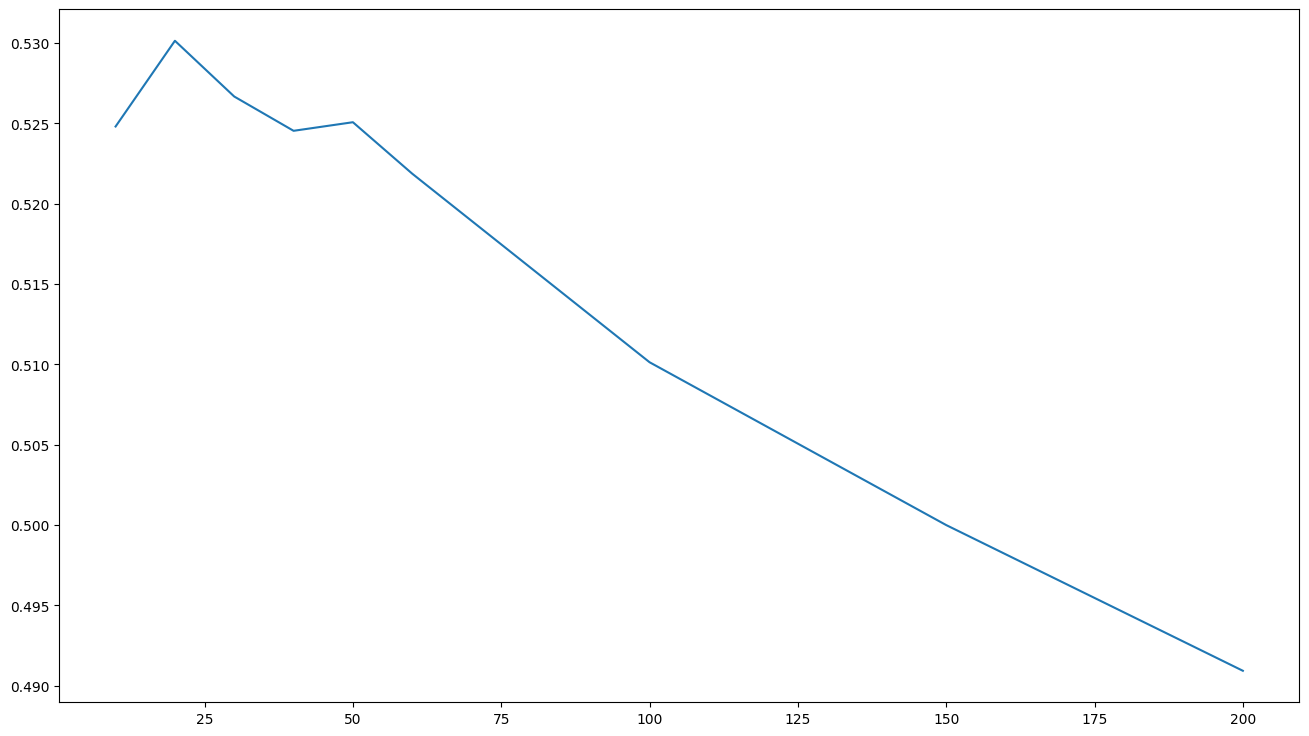

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, 
                                                            test_size=0.15)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=1, 
                                                            test_size=0.15)

# The samples are shuffled
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)
X_validate, y_validate = skl.utils.shuffle(X_train, y_train, random_state=42)
n_neighbors = [10, 20, 30, 40, 50, 60, 100, 150, 200]
cv_scores = []

for n_neighb in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighb) # number got by the paper
    knn.fit(X_train, y_train)
    cv_score = cross_val_score(knn, X_validate, y_validate, cv=4)
    #print(cv_scores)
    cv_scores.append(cv_score)

accuracies = []
for score in cv_scores:
    accuracies.append(np.asarray(score).mean())
plt.figure(figsize=(16,9))
plt.plot(n_neighbors, accuracies)
plt.xlabel("k value")
plt.ylabel("Accuracy")
plt.title("Accuracy for different value of k (# of neighbours) for kNN classifier")
plt.show()

### kNN predictions

In [28]:
n_neigh_best = 0
#pca = PCA(n_components=120)
#pca.fit(X)
#transform = pca.transform(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)
#X_train, X_validation, Y_train, Y_validation = train_test_split(trainX, trainY, random_state=1, 
 #                                                               test_size=15)

knn = KNeighborsClassifier(n_neighbors=n_neigh_best)
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
print(knn.score(X_test, y_test))

knn_precision = precision_score(y_test, knn_predictions, average=None, labels=labels)
knn_recall = recall_score(y_test, knn_predictions, average=None, labels=labels)
knn_f1 = f1_score(y_test, knn_predictions, average=None, labels=labels)
knn_cm = confusion_matrix(y_test, knn_predictions)

print("------------------------- kNN completed -------------------------")

0.6008


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic regression
As third classifier, we show Logistic regression, with $L^2$ loss function

TODO: due parole su logistic regression e sulla loss scelta.

In [29]:
#convertor = skl.preprocessing.LabelEncoder()
#y_train_conv = convertor.fit_transform(y_train)
#y_test_conv = convertor.fit_transform(y_test)
#y_validate_conv = convertor.fit_transform(y_validate)
'''
fit = skl.preprocessing.StandardScaler()
X_train_fit = fit.fit_transform(np.array(X_train, dtype=float))
X_test_fit = fit.fit_transform(np.array(X_test, dtype=float))
X_validate_fit = fit.fit_transform(np.array(X_validate, dtype=float))
'''
fit = skl.preprocessing.StandardScaler()
X = fit.fit_transform(np.array(X, dtype=float))

#pca = PCA(n_components=120)
#pca.fit(X)
#transform = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.10)


# lower the C, the few features will be considered
lr_class = LogisticRegression(C=1, penalty="l2", dual=False).fit(X_train, y_train)
#model = SelectFromModel(lr_class, prefit=True)
#X_train_new = model.transform(X_train_fit)

#lrcv_scores = cross_val_score(lr_class, X_validate_fit, y_validate, cv=10)
#print(cv_scores)

#predictions = lr_class.predict_proba(X_test_fit)
lr_predictions = lr_class.predict(X_test)
#print(preds)

#print(lr_class.score(X_test, y_test))
#print(predictions)

lr_precision = precision_score(y_test, lr_predictions, average=None, labels=labels)
lr_recall = recall_score(y_test, lr_predictions, average=None, labels=labels)
lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
lr_cm = confusion_matrix(y_test, lr_predictions)

print("------------------------- LR completed -------------------------")

0.6084
Linear regression completed


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multi-layer perceptron
Last, we applied multi-layer perceptron.
Parameter to tune:
- number of hidden layers

In [30]:
'''
convertor = skl.preprocessing.LabelEncoder()
y_train = convertor.fit_transform(y_train)
y_test = convertor.fit_transform(y_test)
y_validate = convertor.fit_transform(y_validate)


#print(np.unique(y_train_conv).size)
#print(np.unique(y_test_conv).size)

#print(X_train.columns)

#X_train = X_train.drop['track_id']
fit = skl.preprocessing.StandardScaler()
X_train = fit.fit_transform(np.array(X_train, dtype=float))
X_test = fit.fit_transform(np.array(X_test, dtype=float))
X_validate = fit.fit_transform(np.array(X_validate, dtype=float))
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.15)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150,), random_state=1)
mlp_clf.fit(X_train, y_train)
mlp_predictions = mlp_clf.predict(X_test)

score = mlp_clf.score(X_test, y_test)
print(score)
#print("MLP completed")

mlp_precision = precision_score(y_test, mlp_predictions, average=None, labels=labels)
mlp_recall = recall_score(y_test, mlp_predictions, average=None, labels=labels)
mlp_f1 = f1_score(y_test, mlp_predictions, average=None, labels=labels)
mlp_cm = confusion_matrix(y_test, mlp_predictions)

print("------------------------- MLP completed -------------------------")

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.5749333333333333
MLP completed


# Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

We compute 4 different metrics for each classifier:

| Metric | Expression|
|:-------- | :-------------------------------------------------: |
| Accuracy | $\tfrac{TN + TP}{TP+FP+TN+FN}$ |
| Precision | $\tfrac{TP}{TP + FP}$ |
| Recall | $\tfrac{TP}{TP + FN}$ |
| F1-score | $2 \cdot \tfrac{Precision \cdot Recal}{Precision + Recal}$ |

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

---------------------------------------------------------------------------------------

SVM results:


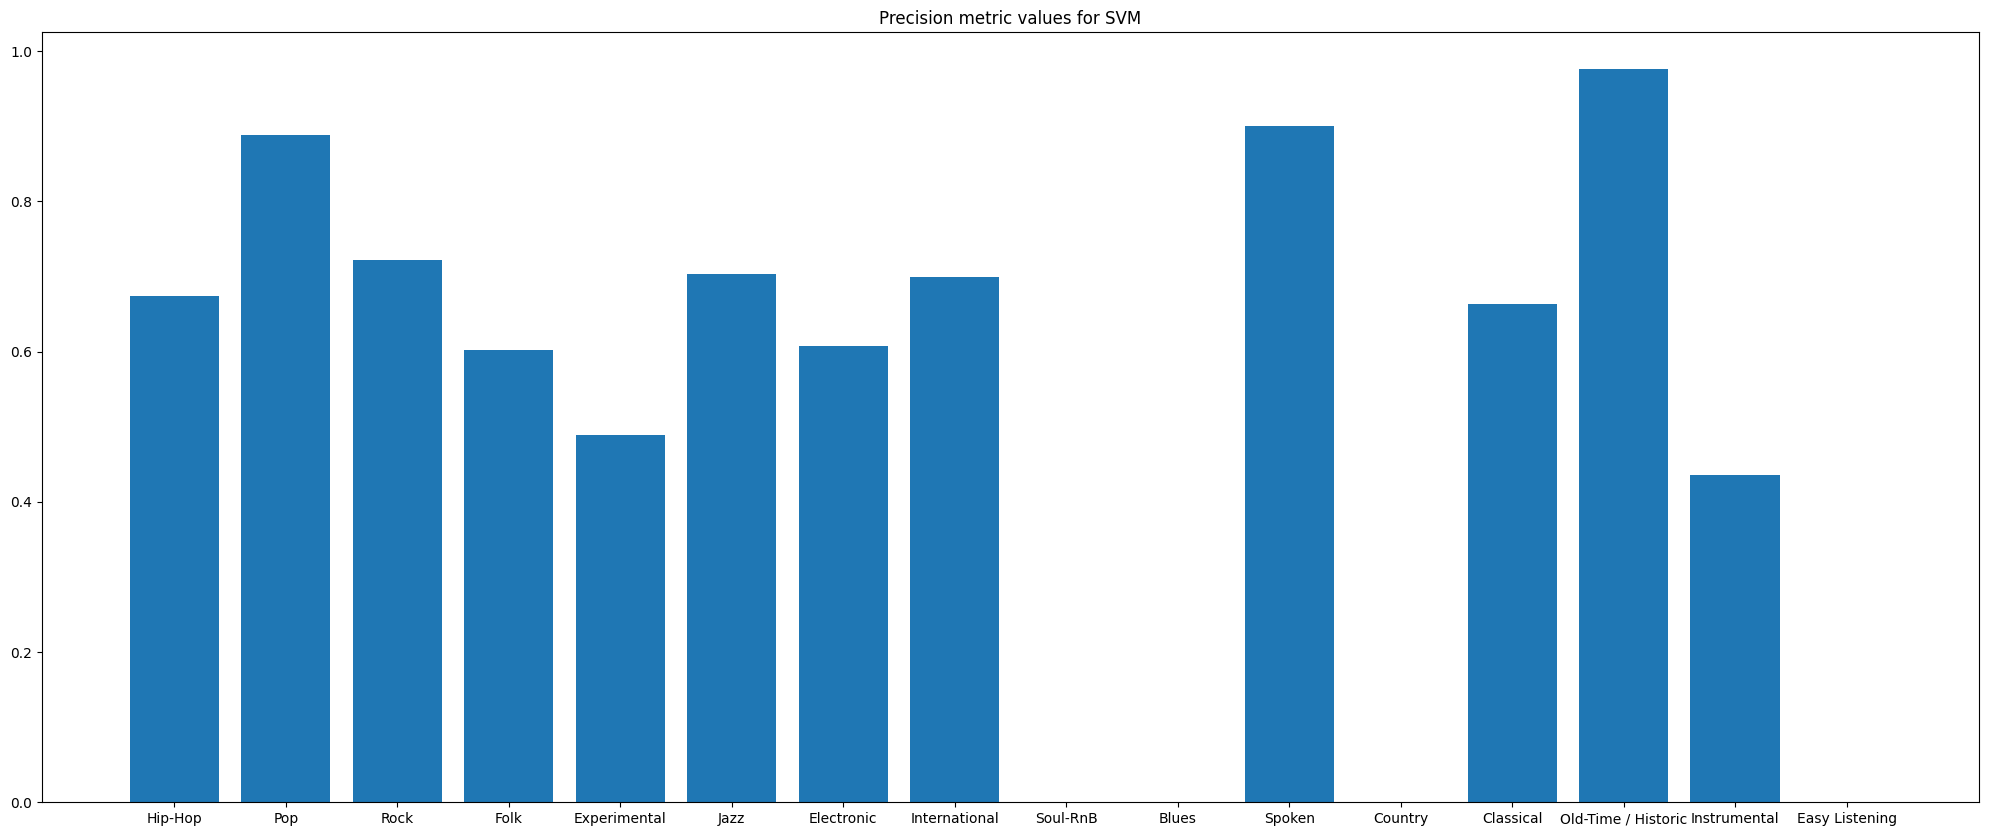

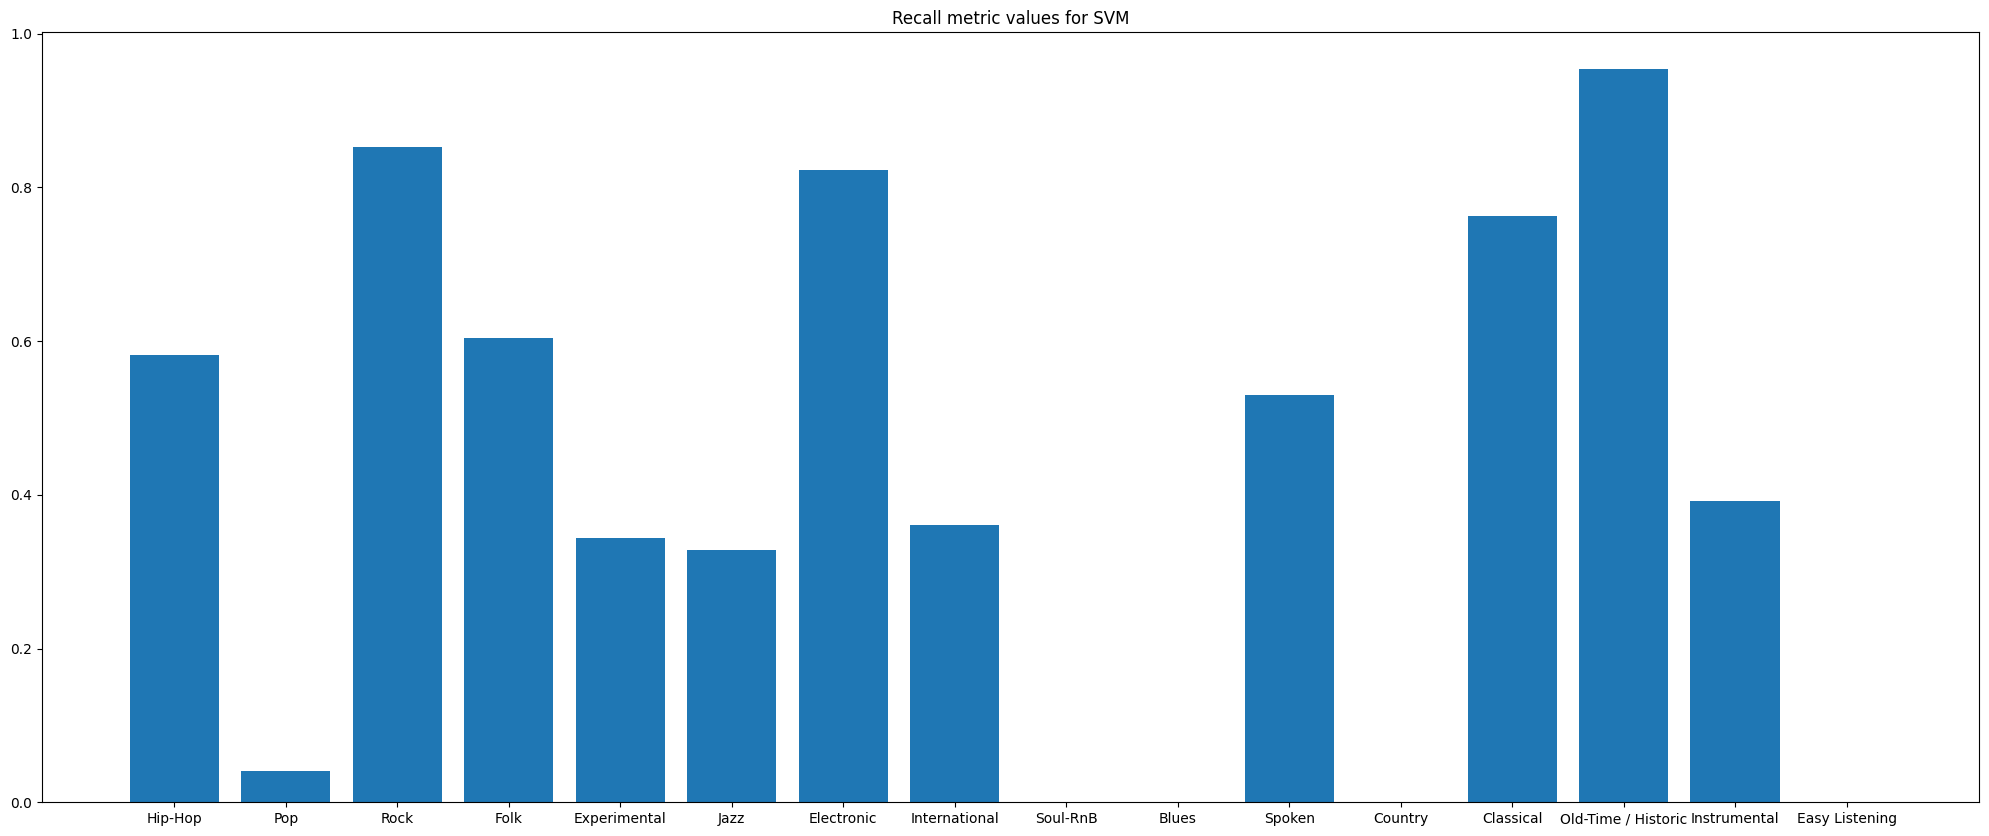

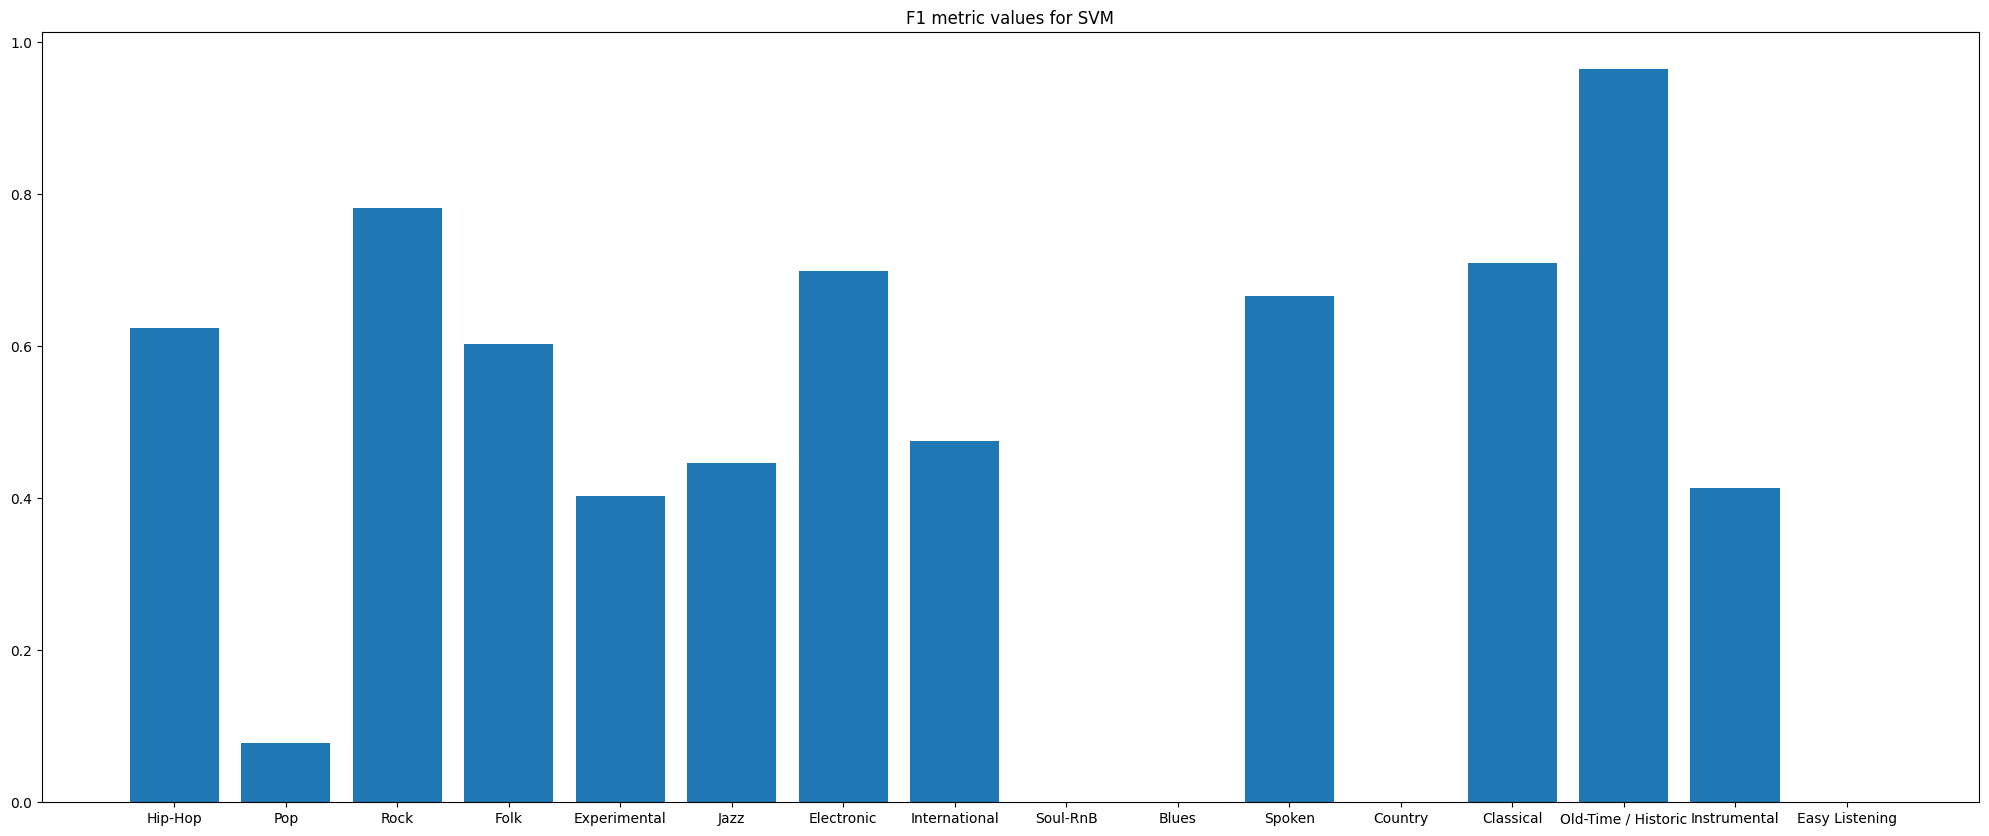

<Figure size 3000x2000 with 0 Axes>

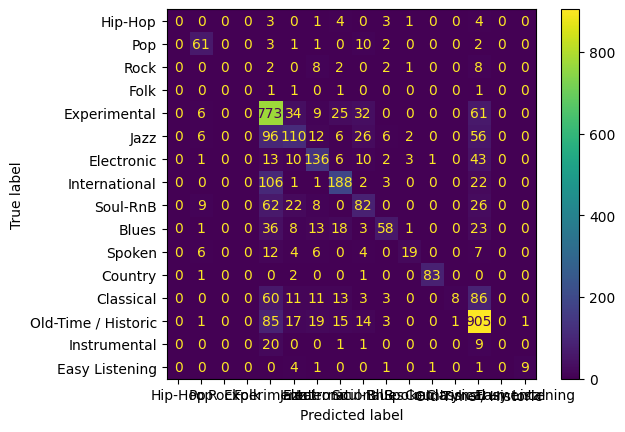

---------------------------------------------------------------------------------------

kNN results: 


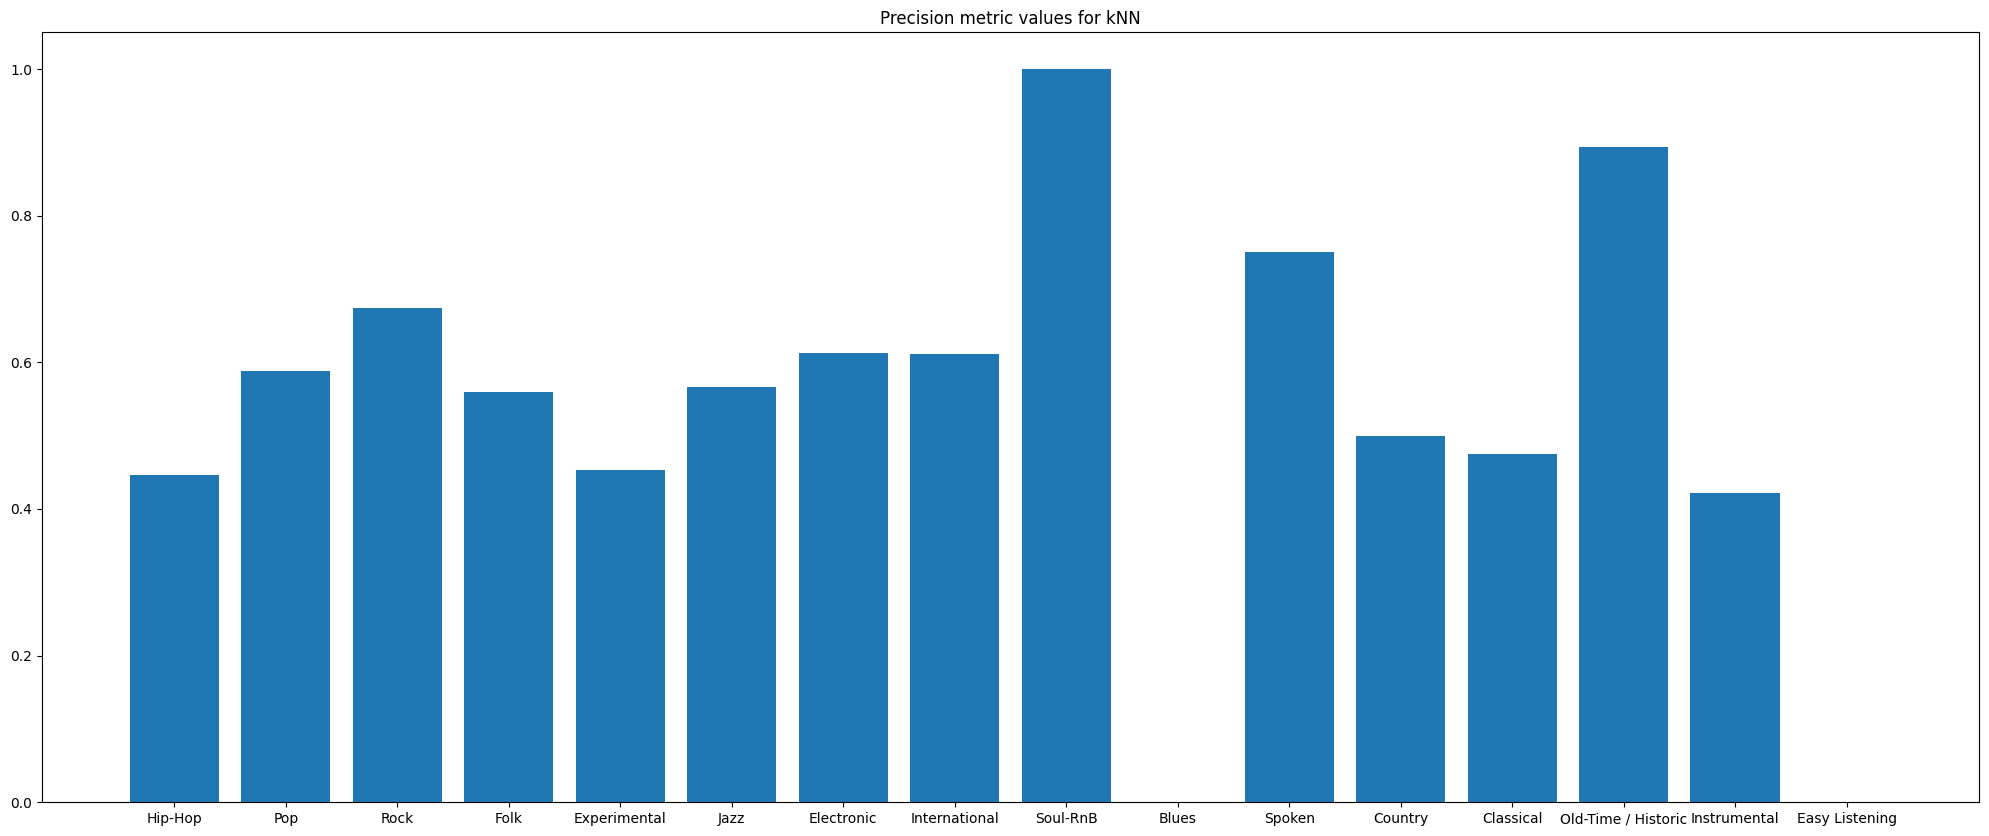

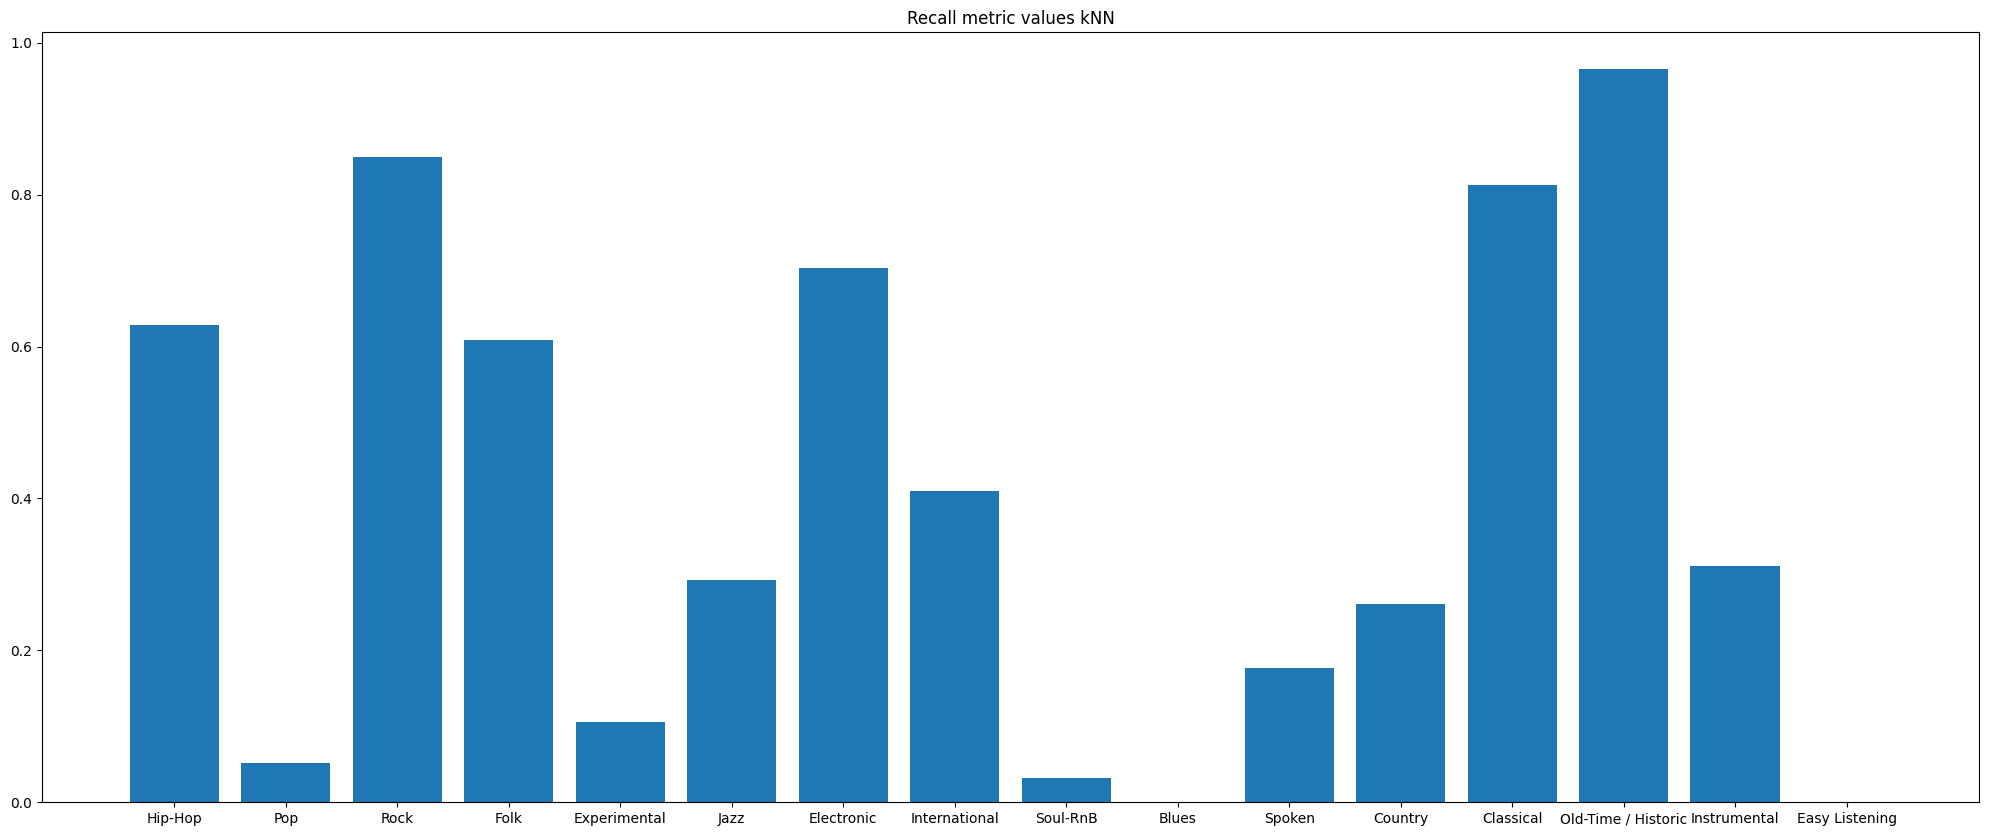

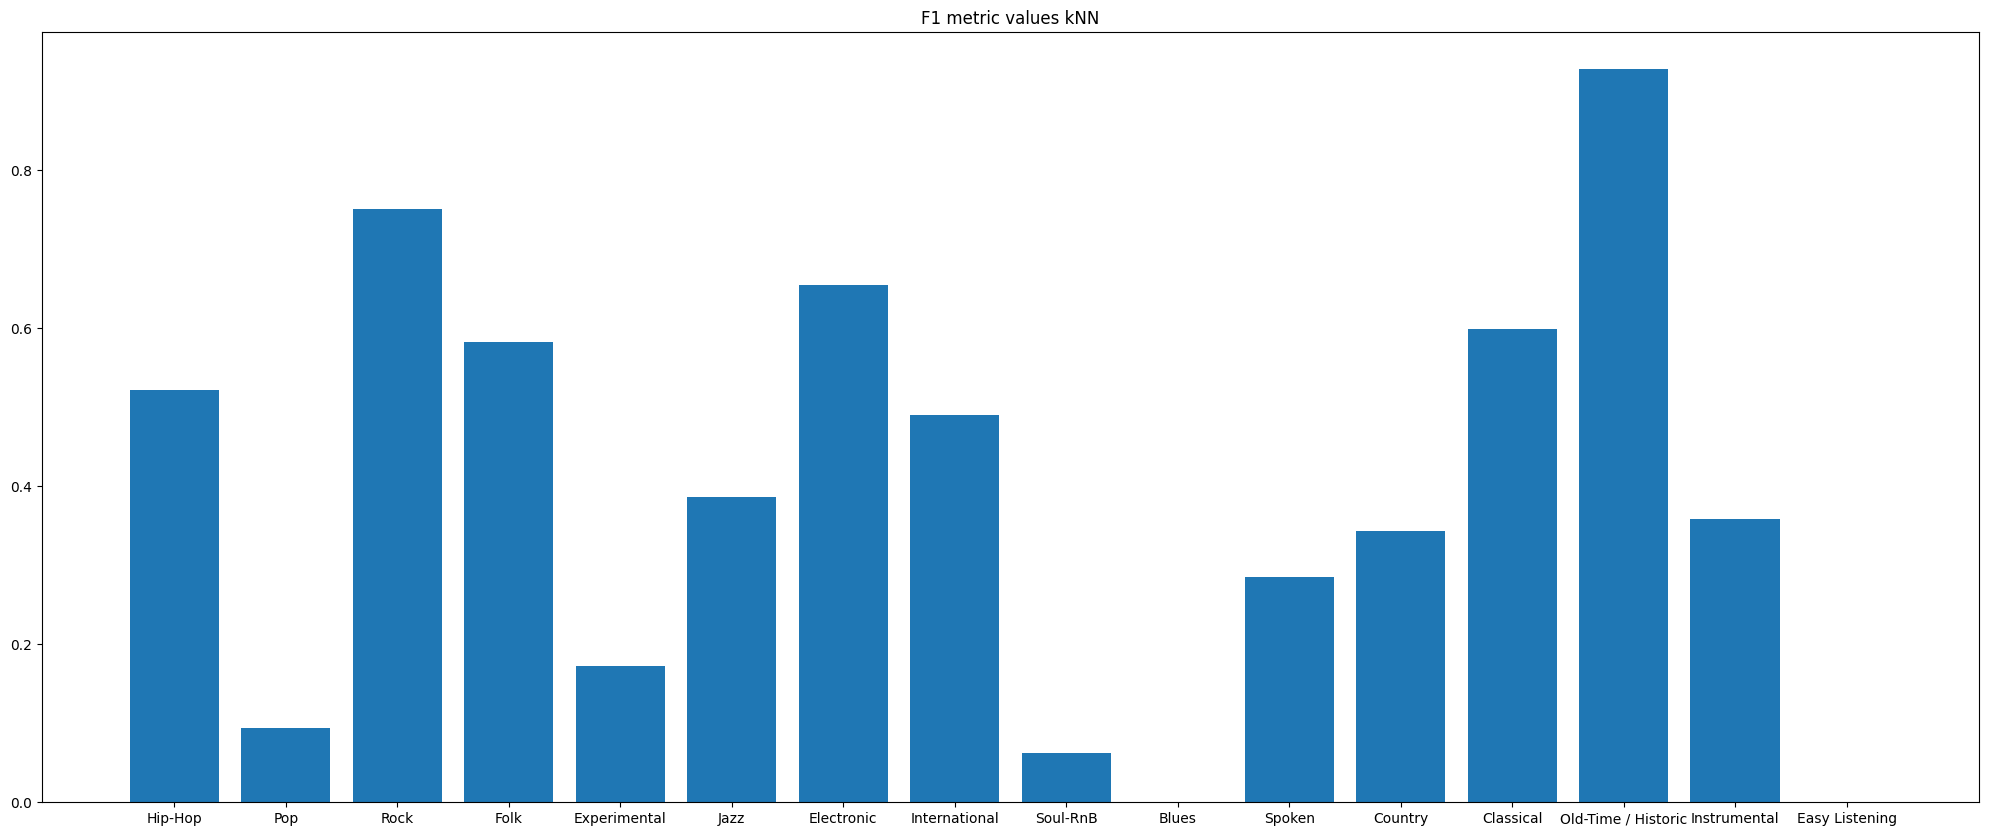

<Figure size 3000x2000 with 0 Axes>

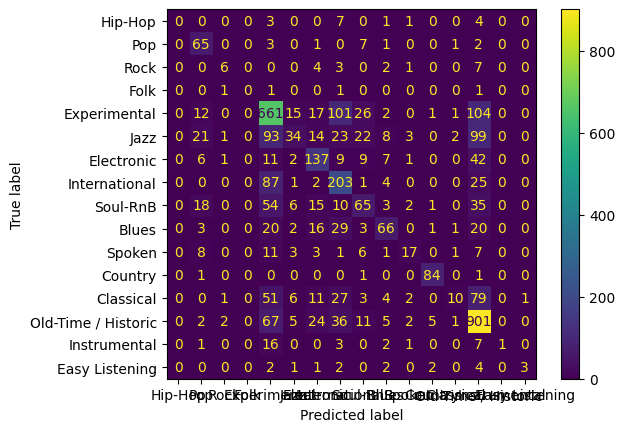

---------------------------------------------------------------------------------------

Linear Regression results: 


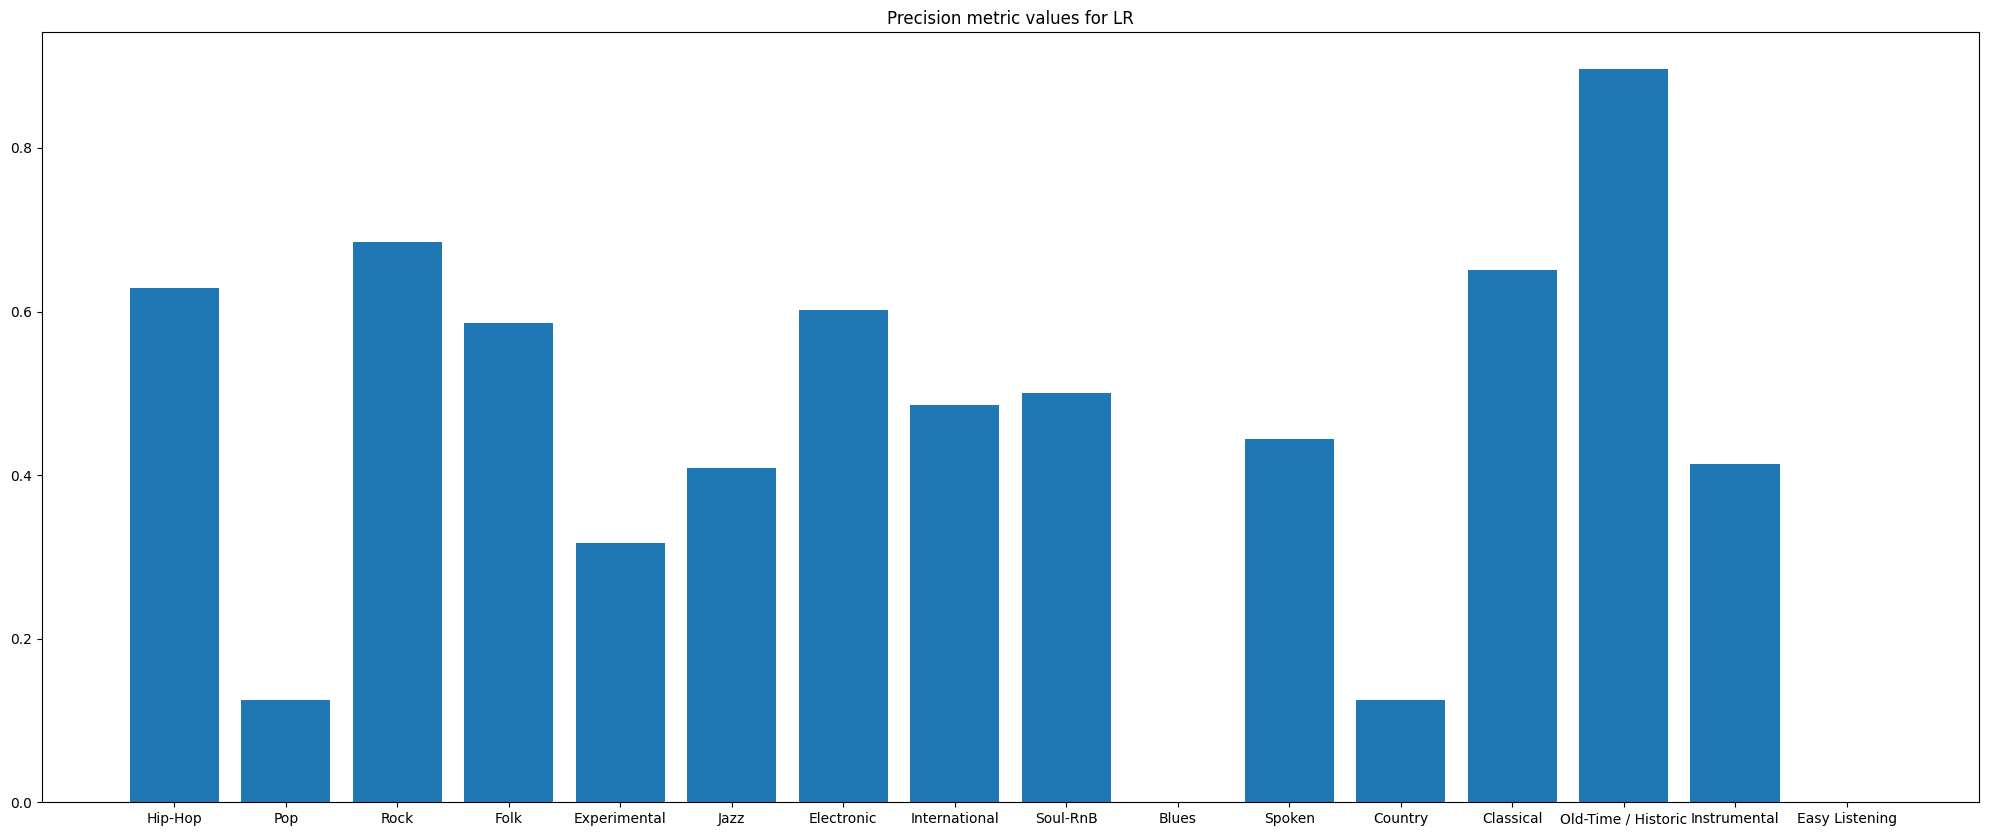

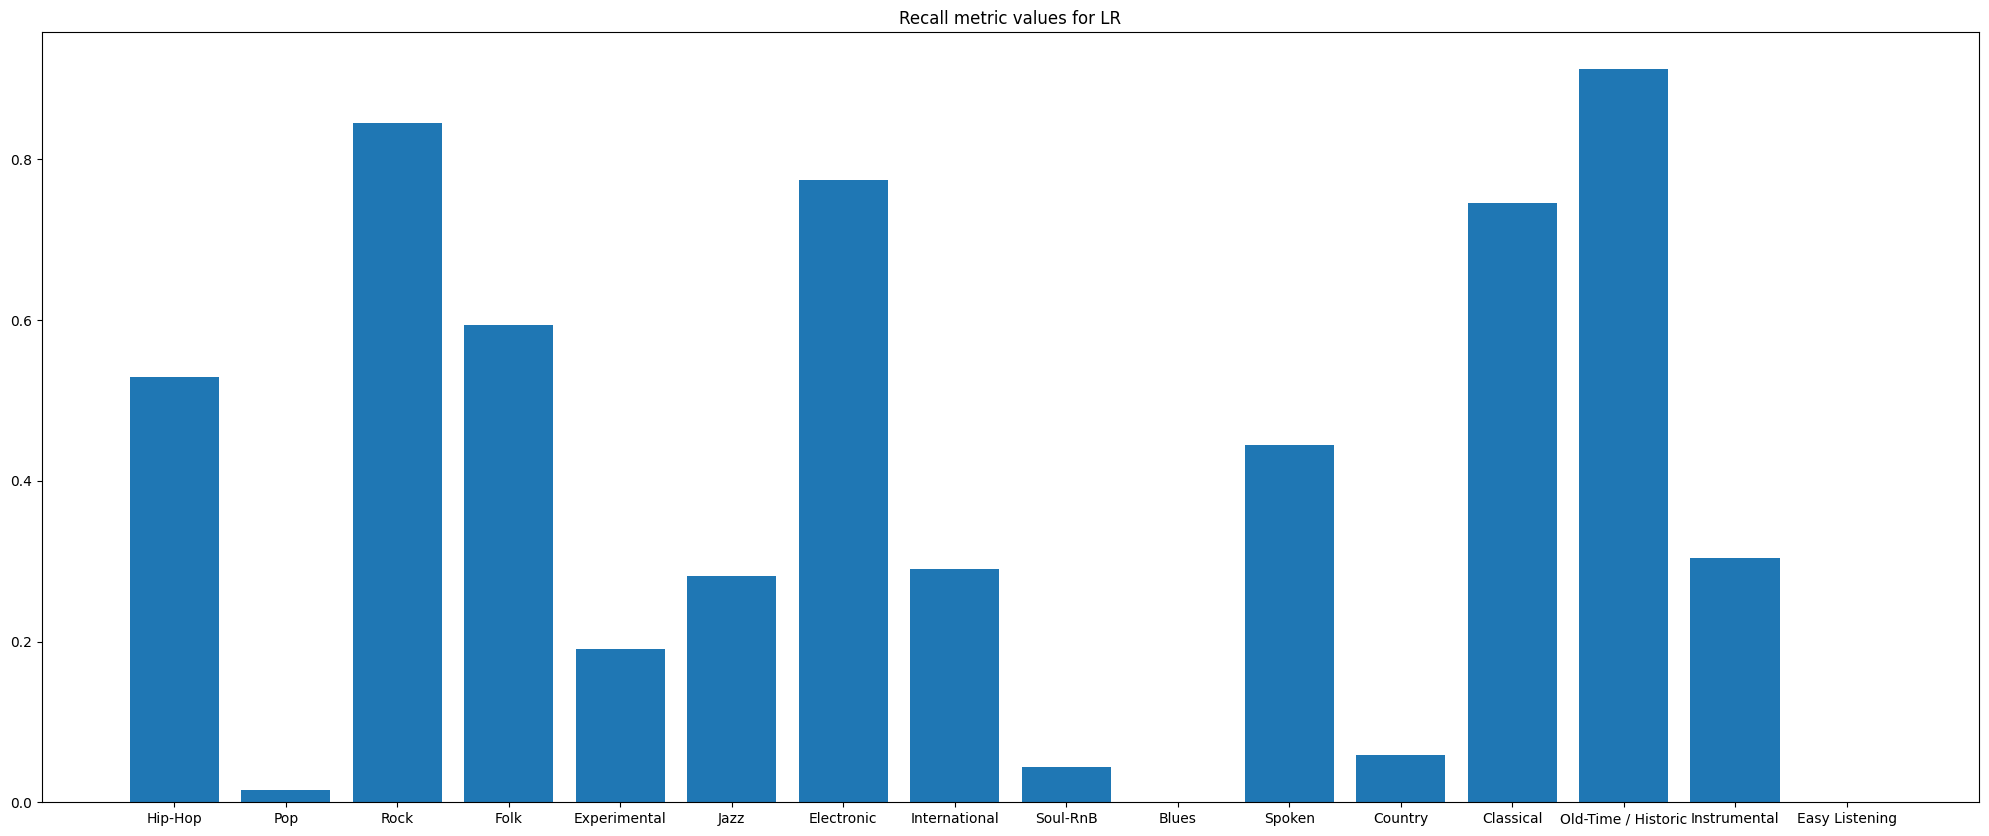

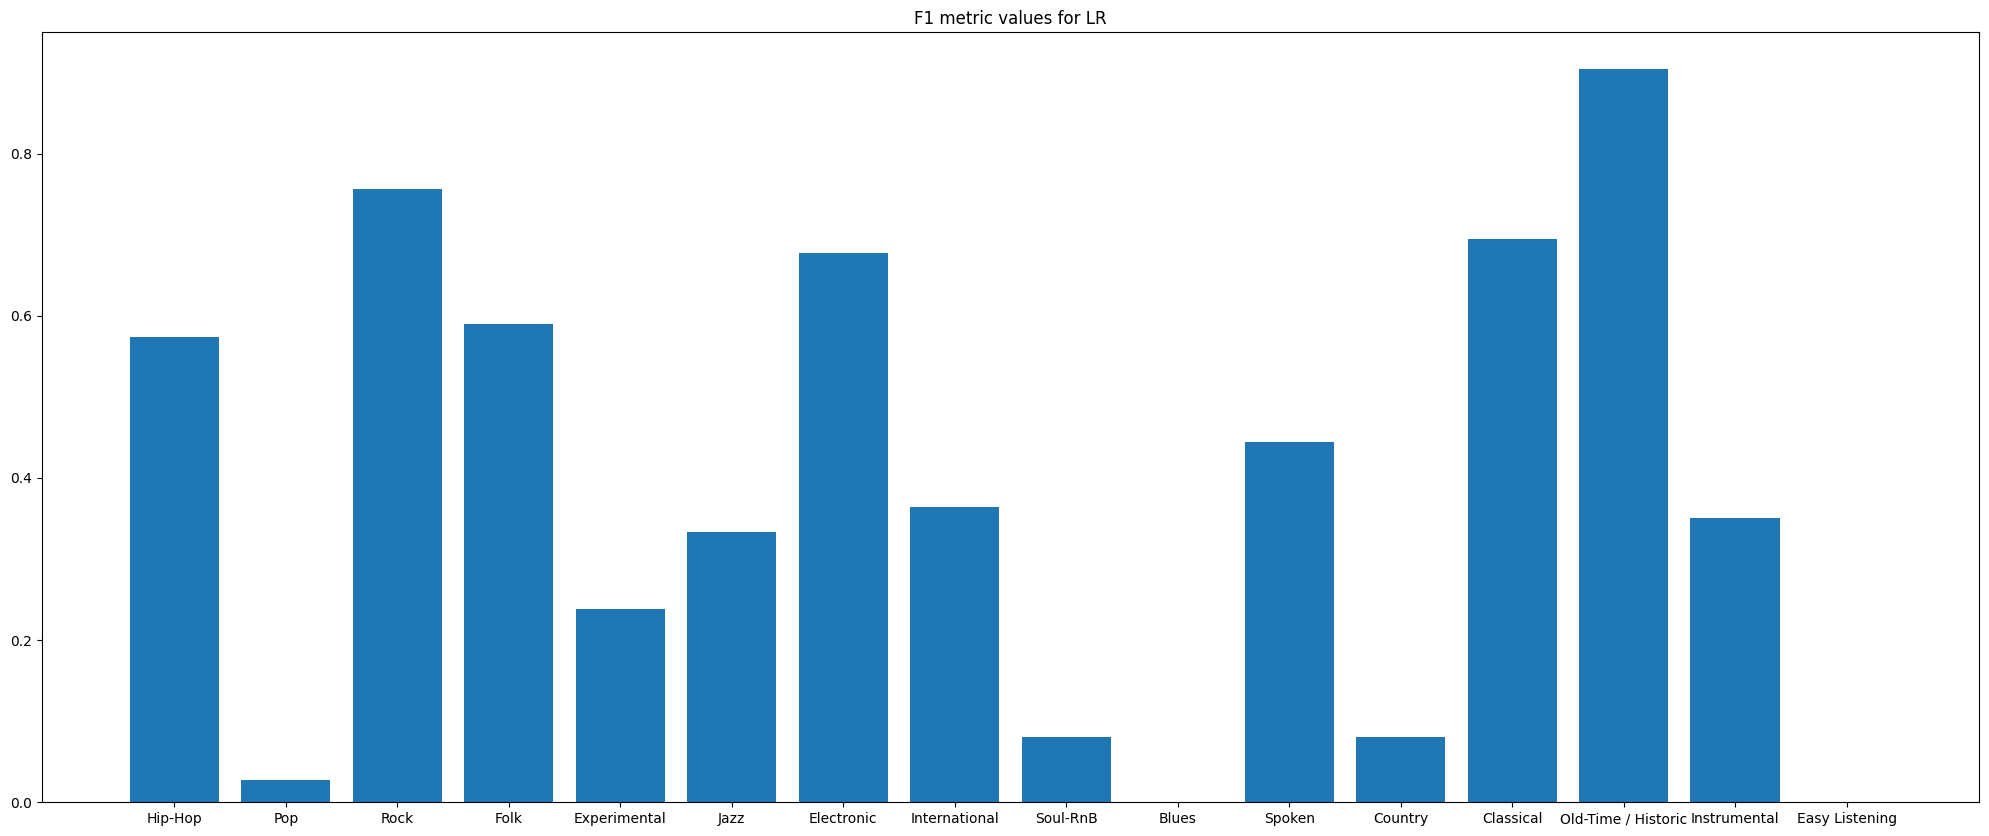

<Figure size 3000x2000 with 0 Axes>

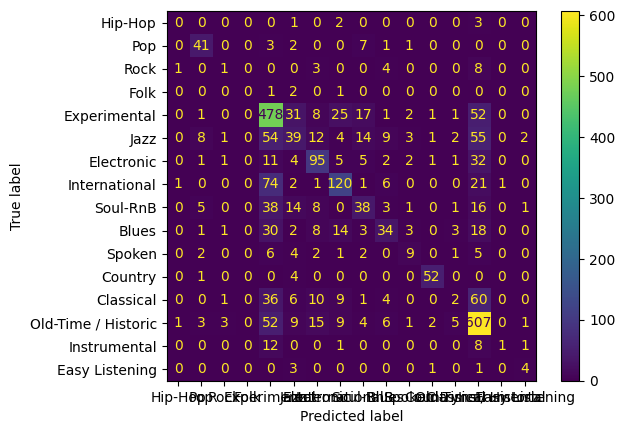

---------------------------------------------------------------------------------------

Multi Layer Perceptron results: 


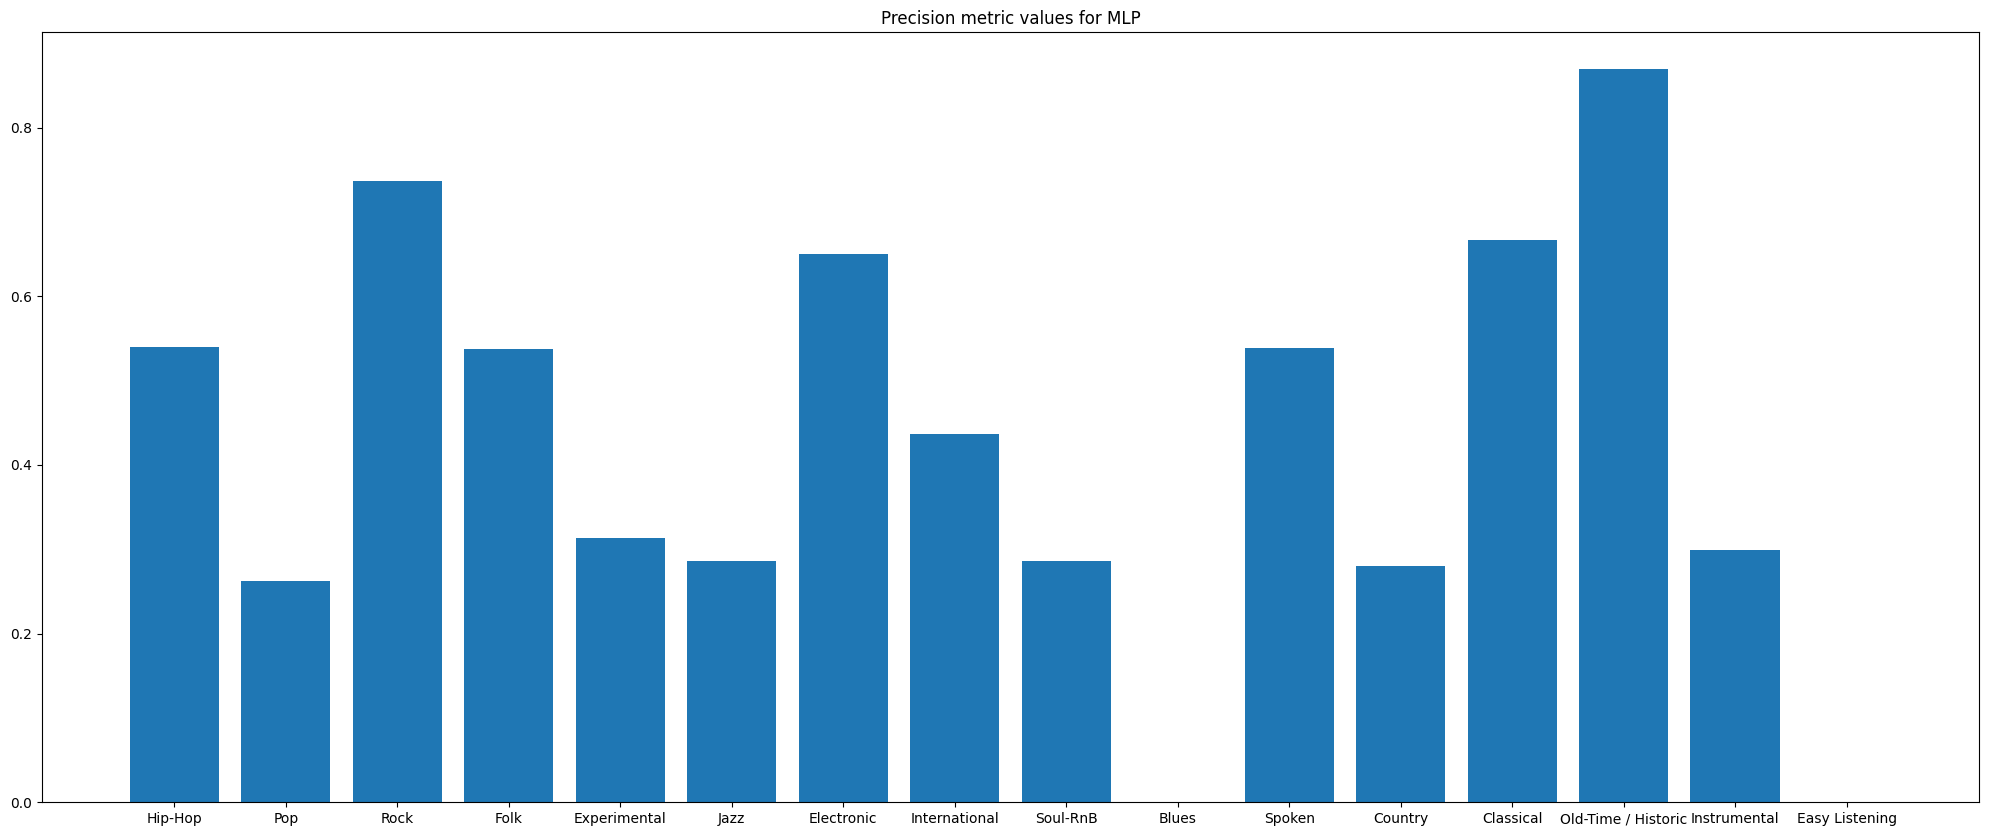

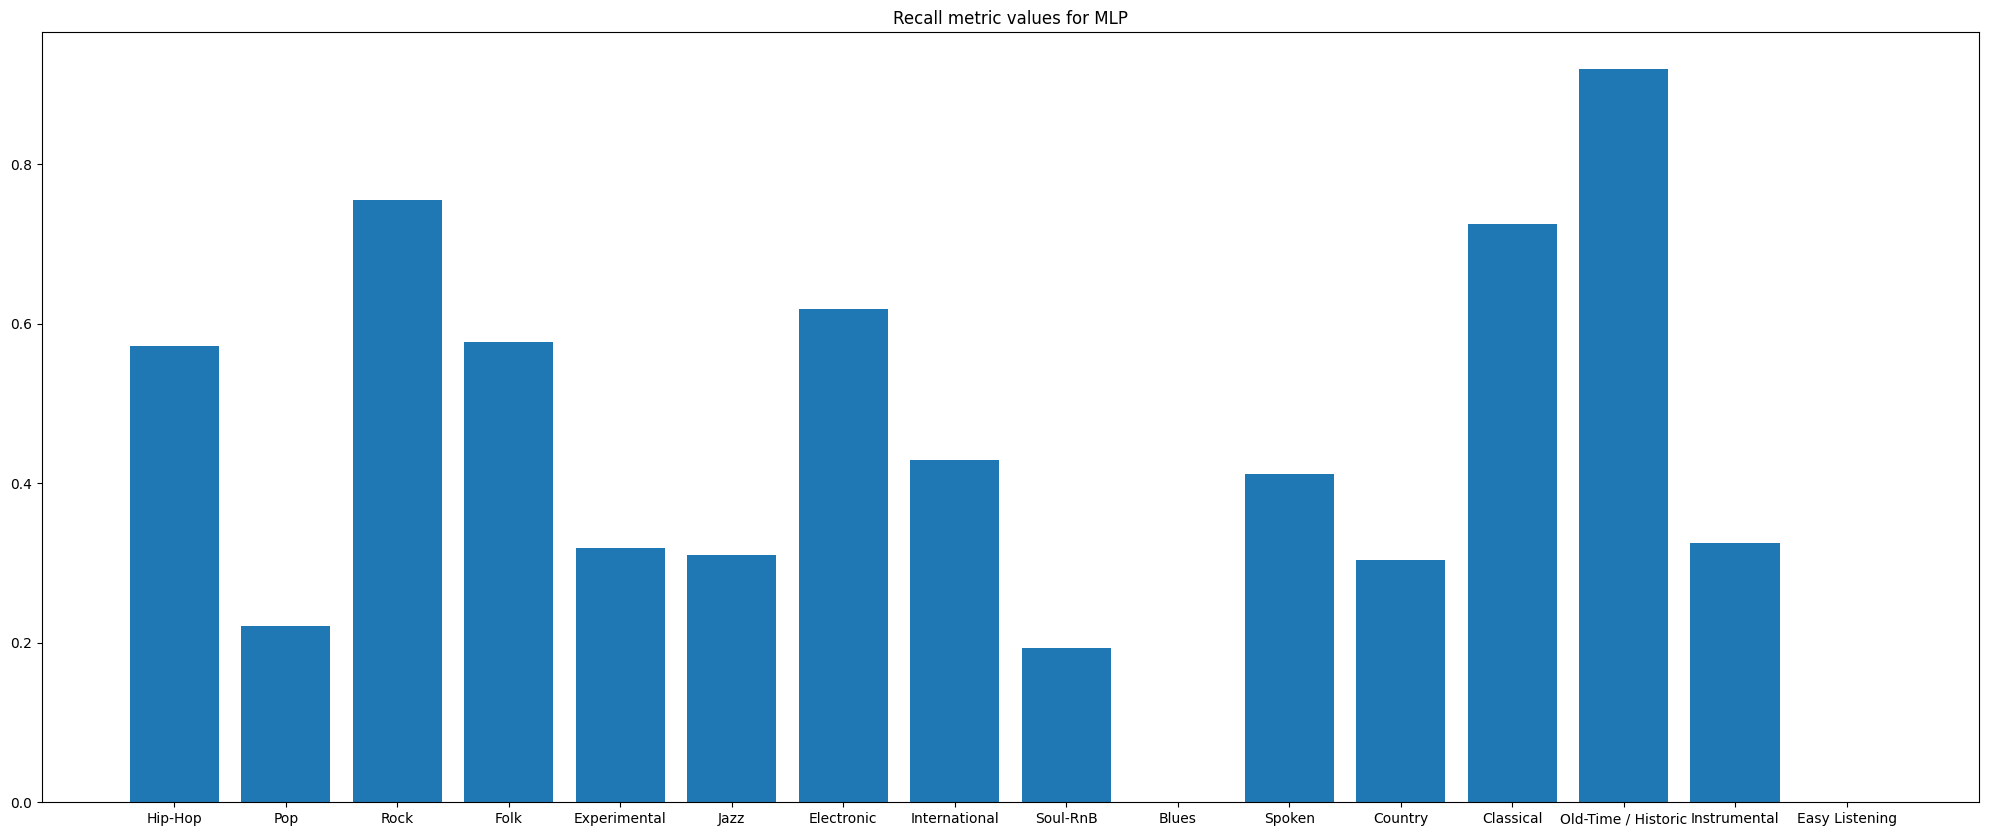

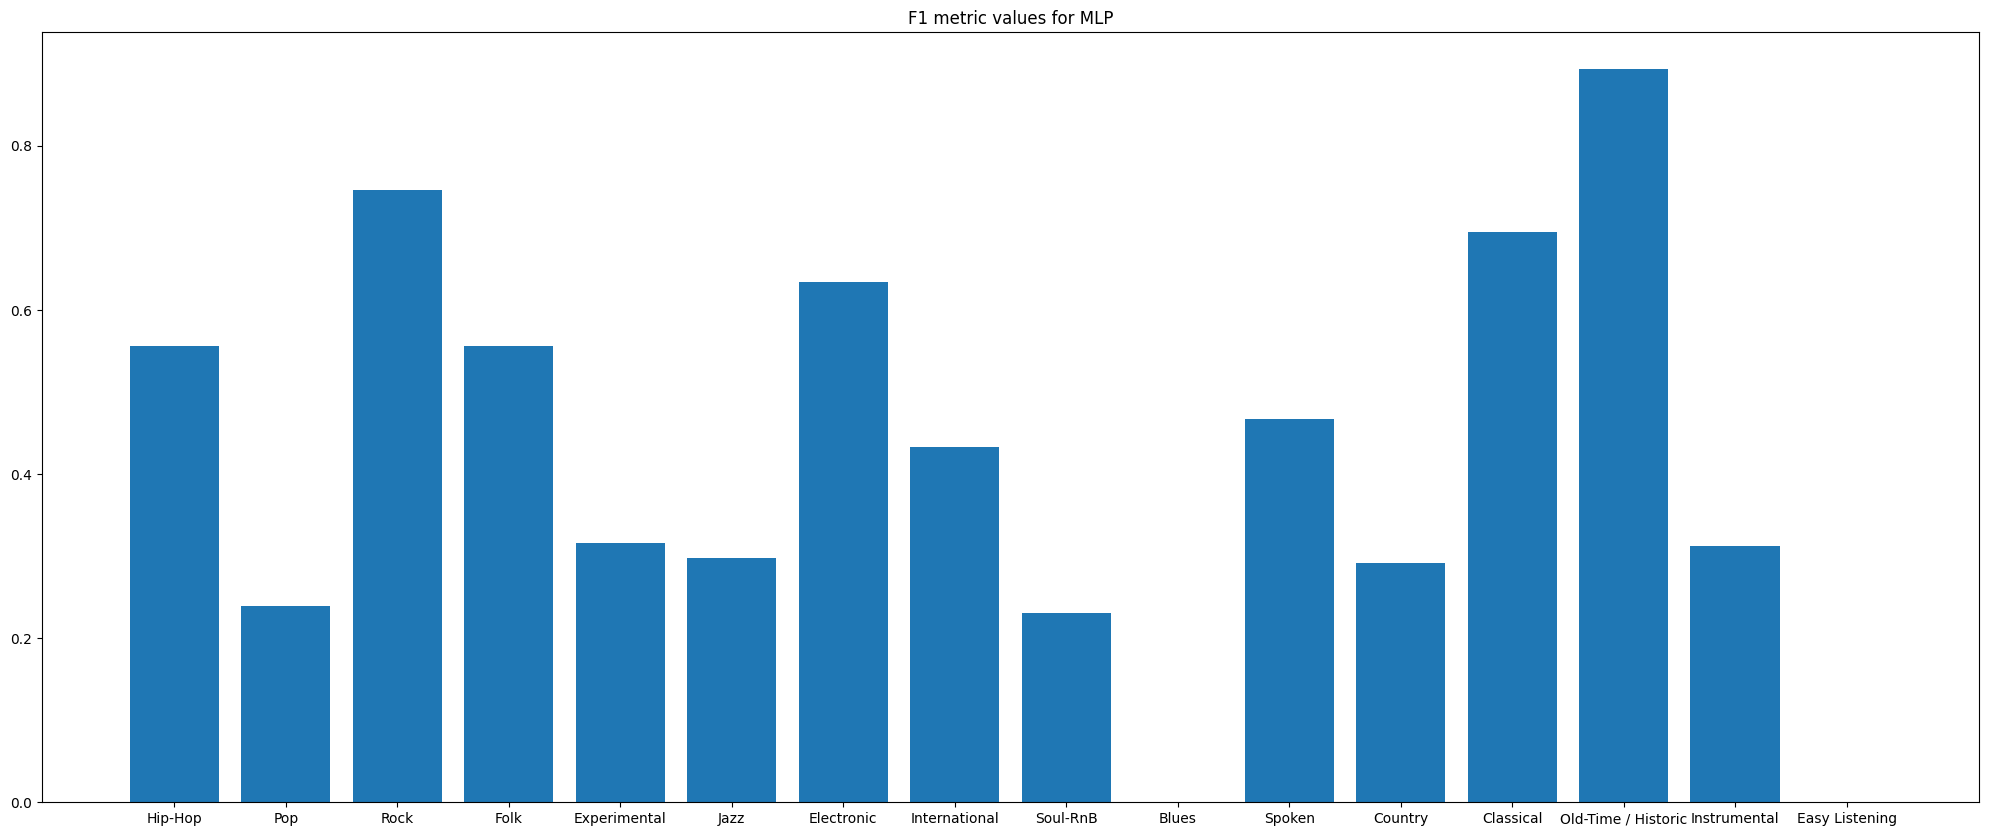

<Figure size 3000x2000 with 0 Axes>

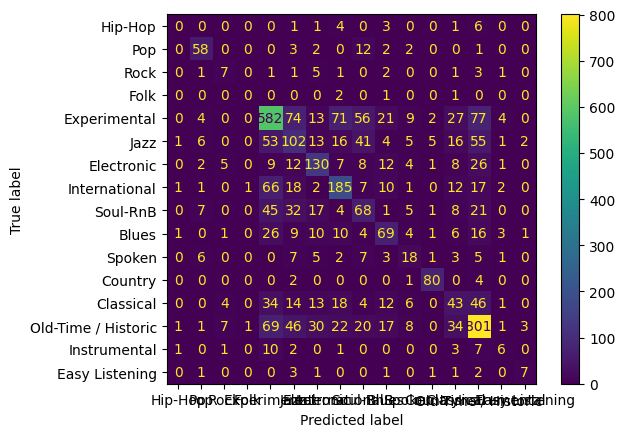

---------------------------------------------------------------------------------------



In [31]:
# TODO: confusion matrix displays wrong label order

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, svm_preds)))

plt.figure(figsize=(25,10))
plt.bar(labels, svm_precision)
plt.title('Precision metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_recall)
plt.title('Recall metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_f1)
plt.title('F1 metric values for SVM')
plt.show()

# Confusion matrix for SVM
#svm_cm = confusion_matrix(y_test, svm_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, knn_predictions)))
plt.figure(figsize=(25,10))
plt.bar(labels, knn_precision)
plt.title('Precision metric values for kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_recall)
plt.title('Recall metric values kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_f1)
plt.title('F1 metric values kNN')
plt.show()

# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, lr_preds)))
plt.figure(figsize=(25,10))
plt.bar(labels, lr_precision)
plt.title('Precision metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_recall)
plt.title('Recall metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_f1)
plt.title('F1 metric values for LR')
plt.show()

# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
plt.figure(figsize=(25,10))
plt.bar(labels, mlp_precision)
plt.title('Precision metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_recall)
plt.title('Recall metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_f1)
plt.title('F1 metric values for MLP')
plt.show()

# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")

# Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

# Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)